# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [43]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [44]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
output="../../Output/"
df = pd.read_csv(file)

In [45]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified
0,25727,2014-03-13,270 CAPITOL AV,7113022,2016-05-02,CONSTRUCTION,10/01/2016,2015-03-19,201303041387,2013-03-04,2013-03-04,2013-03-04,2016-05-02,CONSTRUCTION,"('2013-03-04', '2013-03-04', '2013-03-04', '20...",1307.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",3,2016,Under Construction,4.0,4.0,-122.458789,37.712892,NC-1,NC-1
1,25295,NaN,1369 29TH AV,1784001O,2016-04-18,BP FILED,NaN,NaN,201604185001,2016-04-18,2016-04-18,2016-04-18,2016-04-18,BP FILED,"('2016-04-18', '2016-04-18')",NaN,"('BP FILED', 'BP FILED')",3,2016,Proposed,2.0,1.0,-122.488077,37.761786,RH-1,RH-1
2,19276,NaN,950 CORBETT AV,2799083,2007-03-13,CONSTRUCTION,07/01/2015,2007-03-13,200201106632.0,2007-03-13,2007-03-13,NaN,2007-03-13,CONSTRUCTION,"('2007-03-13',)",3032.0,"('CONSTRUCTION',)",2,2015,Under Construction,3.0,3.0,-122.443730,37.751832,RM-1,RM-1
3,26372,NaN,935 KANSAS ST (1 OF 5 BLDG),4094045,2014-07-02,BP FILED,NaN,NaN,201407020323,2014-07-02,2014-07-02,2014-07-02,2014-07-02,BP FILED,"('2014-07-02', '2014-07-02')",NaN,"('BP FILED', 'BP FILED')",3,2016,Proposed,2.0,2.0,-122.402570,37.757895,RH-2,RH-2
4,21603,2008-01-25,270 OCEAN AV,3211010A,2015-06-26,CONSTRUCTION,01/01/2016,2015-01-30,200607186852.0,2006-07-18,2008-01-25,2006-07-18,2015-06-26,CONSTRUCTION,"('2008-01-25', '2008-01-25', '2008-01-25', '20...",3454.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2015,Under Construction,6.0,6.0,-122.442378,37.723474,NC-1,NC-1


In [46]:
def comp_year(value):
    returnval=''
    if pd.isnull(value['comp_date']):
        returnval=''
    else:
        returnval=value['comp_date'][6:10]
    return returnval
df['comp_year']=df.apply(comp_year, axis=1)

In [47]:
def permit_year(value):
    returnval=''
    if pd.isnull(value['BP_date']):
        returnval=''
    else:
        returnval=value['BP_date'][0:4]
    return returnval
df['permit_year']=df.apply(permit_year, axis=1)

In [48]:
df.to_csv(output+"all_obs.csv") #requested by Manoj

# Initial Data Cleaning

In [155]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [159]:
#Next, keep only those that reached completion at some point over the time period
df=df[pd.notnull(df['comp_date'])]

In [160]:
df.shape

(792, 26)

In [112]:
df=df[pd.notnull(df['firstfiled'])]
df=df[df['firstfiled'] !='']

In [113]:
df.shape

(786, 26)

In [114]:
#drop duplicates for now, until manual cleaning is done
df= df[~ df.duplicated('dbi_permit', keep=False)]

In [115]:
df.shape

(713, 26)

In [116]:
df['project_time_years']=df['project_duration_days']/365

In [117]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years
189,18560,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,-122.392222,37.717174,RH-2,RH-2,24.128767
1610,26437,NaN,POTRERO1010 (BLDG 1 OF 2),3833001,2016-05-26,CONSTRUCTION,10/01/2016,2016-05-26,201112070227,2000-05-18,2016-05-26,2000-05-18,2016-05-26,CONSTRUCTION,"('2016-05-26', '2016-05-26')",5980.0,"('CONSTRUCTION', 'CONSTRUCTION')",3,2016,Under Construction,65.0,65.0,-122.396595,37.767108,UMU,UMU,16.383562
495,17247,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819.0,1999-02-11,2008-11-07,1999-02-11,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,-122.389058,37.755993,UMU,UMU,15.898630
1289,24780,2014-02-12,480 POTRERO AV,3973002C,2016-01-13,CONSTRUCTION,07/01/2016,2015-03-26,201306250465,2002-03-22,2004-08-17,2002-03-22,2016-01-13,CONSTRUCTION,"('2004-08-17', '2012-10-04', '2012-10-04', '20...",5215.0,"('BP ISSUED', 'PL FILED', 'PL FILED', 'BP FILE...",2,2016,Under Construction,77.0,77.0,-122.407671,37.763478,UMU,UMU,14.287671
2270,27882,2013-10-31,TRINITY PLAZA PHASE III,3702391,2016-11-09,CONSTRUCTION,01/01/2017,2015-10-14,201209069080,2002-11-21,2013-10-31,2002-11-21,2016-11-09,CONSTRUCTION,"('2013-10-31', '2015-10-14', '2015-12-21', '20...",5155.0,"('BP ISSUED', 'CONSTRUCTION', 'CONSTRUCTION', ...",4,2016,Under Construction,550.0,550.0,-122.413013,37.777926,C-3-G,C-3-G,14.123288


In [118]:
# Top 5 shortest projects
df.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years
1594,2346,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,RH-2,RH-2,0.430137
3156,21046,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,2015-10-05,2015-10-05,201504103396.0,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",178.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,-122.407649,37.726252,RH-1,RH-1,0.487671
982,10897,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,-122.407185,37.783461,C-3-R,C-3-R,0.534247
1023,10900,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,-122.418489,37.746472,RH-2,RH-2,0.534247
2718,656,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,PDR-1-G,PDR-1-G,0.536986


In [119]:
#Manual Data Cleaning for some fishy values based on top 5 shortest list above
#df.loc[(df['address']=='55 05TH ST') & (new_df['apn']=='3705039'), 'units'] = 8 #looked up on PIM. Simple adding 8 units.
#df.loc[(df['address']=='545 POST ST') & (new_df['apn']=='0306022'), 'units'] = 4 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='555 POST ST') & (new_df['apn']=='0306020'), 'units'] = 17 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='515 JOHN MUIR DR') & (new_df['apn']=='7282005'), 'units'] = 2 #looked up on PIM. Change of use to residential. 2 additional units

#based on the above cases, unit count seems to be the unit count at the site at the end of 
#the project rather than the unit count of the project itself. Because of this, I will be adjust
#unit counts that are more than the net units added to the net units added amount. If units net
#is missing, just accept unit count as true for now.

def unit_change(value):
    return_val=value['units']
    if pd.notnull(value['unitsnet']):
        if value['unitsnet']<0:
            return_val = value['units']
        elif value['unitsnet']==0:
            return_val = value['units']
        elif value['unitsnet']<value['units']:
            return_val = value['unitsnet']
        else:
            return_val=value['units']
    return return_val

df['units']=df.apply(unit_change, axis=1)
 

In [120]:
#Create Big Projects Dataframe
df_big=df[df['units']>=10]
df_big['project_time_years'].describe()

count    152.000000
mean       6.008616
std        3.467567
min        0.750685
25%        3.497945
50%        5.400000
75%        7.811644
max       24.128767
Name: project_time_years, dtype: float64

In [121]:
df['project_time_years'].describe()

count    713.000000
mean       4.516851
std        3.064934
min        0.430137
25%        2.106849
50%        3.808219
75%        6.323288
max       24.128767
Name: project_time_years, dtype: float64

# Merge in Geographic Information and Make Big Dataframe

In [122]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [123]:
tracts = gpd.read_file("../../../data/Census/ACS_2015_5YR_TRACT_06_CALIFORNIA.gdb")
#convert boundaries to geographic coordinate system to conform to points
tracts = tracts.to_crs({'init': 'epsg:4326'}) 

In [124]:
tables = ['B25003', 'B19001', 'B01001', 'B02001', 'S0101', 'S1901', 'B25077', 'B25038']

In [125]:
for table in tables: 
    new_table = pd.read_csv("../../../data/Census/ACS_15_5YR_"+table+"_with_ann.csv", header=1)
    new_table = new_table.drop(['Id', 'Geography'], axis=1) #drop unnecessary variables
    new_table = new_table[new_table.columns.drop(list(new_table.filter(regex='Margin of Error')))] #drop MOE columns for now
    new_table = new_table.rename(columns={'Estimate; Total:': 'Estimate; Total:'+'_'+table}) #rename estimate "total" column
    new_table['Id2']=new_table['Id2'].astype(str).apply(lambda x: x.zfill(11))
    tracts = pd.merge(tracts, new_table, left_on='GEOID', right_on='Id2', how='inner') #inner join to get rid of non-SF tracts

In [126]:
tracts.head()

,ALAND,AWATER,COUNTYFP,FUNCSTAT,GEOID,GEOID_Data,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,Shape_Area,Shape_Length,TRACTCE,geometry,Id2_x,Estimate; Total:_B25003,Estimate; Total: - Owner occupied,Estimate; Total: - Renter occupied,Id2_y,Estimate; Total:_B19001,"Estimate; Total: - Less than $10,000","Estimate; Total: - $10,000 to $14,999","Estimate; Total: - $15,000 to $19,999","Estimate; Total: - $20,000 to $24,999","Estimate; Total: - $25,000 to $29,999","Estimate; Total: - $30,000 to $34,999","Estimate; Total: - $35,000 to $39,999","Estimate; Total: - $40,000 to $44,999","Estimate; Total: - $45,000 to $49,999","Estimate; Total: - $50,000 to $59,999","Estimate; Total: - $60,000 to $74,999","Estimate; Total: - $75,000 to $99,999","Estimate; Total: - $100,000 to $124,999","Estimate; Total: - $125,000 to $149,999","Estimate; Total: - $150,000 to $199,999","Estimate; Total: - $200,000 or more",Id2_x,Estimate; Total:_B01001,Estimate; Male:,Estimate; Male: - Under 5 years,Estimate; Male: - 5 to 9 years,Estimate; Male: - 10 to 14 years,Estimate; Male: - 15 to 17 years,Estimate; Male: - 18 and 19 years,Estimate; Male: - 20 years,Estimate; Male: - 21 years,Estimate; Male: - 22 to 24 years,Estimate; Male: - 25 to 29 years,Estimate; Male: - 30 to 34 years,Estimate; Male: - 35 to 39 years,Estimate; Male: - 40 to 44 years,Estimate; Male: - 45 to 49 years,Estimate; Male: - 50 to 54 years,Estimate; Male: - 55 to 59 years,Estimate; Male: - 60 and 61 years,Estimate; Male: - 62 to 64 years,Estimate; Male: - 65 and 66 years,Estimate; Male: - 67 to 69 years,Estimate; Male: - 70 to 74 years,Estimate; Male: - 75 to 79 years,Estimate; Male: - 80 to 84 years,Estimate; Male: - 85 years and over,Estimate; Female:,Estimate; Female: - Under 5 years,Estimate; Female: - 5 to 9 years,Estimate; Female: - 10 to 14 years,Estimate; Female: - 15 to 17 years,Estimate; Female: - 18 and 19 years,Estimate; Female: - 20 years,Estimate; Female: - 21 years,Estimate; Female: - 22 to 24 years,Estimate; Female: - 25 to 29 years,Estimate; Female: - 30 to 34 years,Estimate; Female: - 35 to 39 years,Estimate; Female: - 40 to 44 years,Estimate; Female: - 45 to 49 years,Estimate; Female: - 50 to 54 years,Estimate; Female: - 55 to 59 years,Estimate; Female: - 60 and 61 years,Estimate; Female: - 62 to 64 years,Estimate; Female: - 65 and 66 years,Estimate; Female: - 67 to 69 years,Estimate; Female: - 70 to 74 years,Estimate; Female: - 75 to 79 years,Estimate; Female: - 80 to 84 years,Estimate; Female: - 85 years and over,Id2_y,Estimate; Total:_B02001,Estimate; Total: - White alone,Estimate; Total: - Black or African American alone,Estimate; Total: - American Indian and Alaska Native alone,Estimate; Total: - Asian alone,Estimate; Total: - Native Hawaiian and Other Pacific Islander alone,Estimate; Total: - Some other race alone,Estimate; Total: - Two or more races:,Estimate; Total: - Two or more races: - Two races including Some other race,"Estimate; Total: - Two or more races: - Two races excluding Some other race, and three or more races",Id2_x,Total; Estimate; Total population,Male; Estimate; Total population,Female; Estimate; Total population,Total; Estimate; AGE - Under 5 years,Male; Estimate; AGE - Under 5 years,Female; Estimate; AGE - Under 5 years,Total; Estimate; AGE - 5 to 9 years,Male; Estimate; AGE - 5 to 9 years,Female; Estimate; AGE - 5 to 9 years,Total; Estimate; AGE - 10 to 14 years,Male; Estimate; AGE - 10 to 14 years,Female; Estimate; AGE - 10 to 14 years,Total; Estimate; AGE - 15 to 19 years,Male; Estimate; AGE - 15 to 19 years,Female; Estimate; AGE - 15 to 19 years,Total; Estimate; AGE - 20 to 24 years,Male; Estimate; AGE - 20 to 24 years,Female; Estimate; AGE - 20 to 24 years,Total; Estimate; AGE - 25 to 29 years,Male; Estimate; AGE - 25 to 29 years,Female; Estimate; AGE - 25 to 29 years,Total; Estimate; AGE - 30 to 34 years,Male; Estimate; AGE - 30 to 34 years,Female; Estimate; AGE - 30 to 34 years,Total; Estimate; AGE - 35 to 39 years,Male; Estimate; AGE

In [127]:
#consolidate income categories
twentyfive=['Estimate; Total: - Less than $10,000', 'Estimate; Total: - $10,000 to $14,999', 
           'Estimate; Total: - $15,000 to $19,999', 'Estimate; Total: - $20,000 to $24,999']

fifty = ['Estimate; Total: - $25,000 to $29,999', 'Estimate; Total: - $30,000 to $34,999',
        'Estimate; Total: - $35,000 to $39,999', 'Estimate; Total: - $40,000 to $44,999',
        'Estimate; Total: - $45,000 to $49,999']
         
seven_five=['Estimate; Total: - $50,000 to $59,999','Estimate; Total: - $60,000 to $74,999']
           
hundred = ['Estimate; Total: - $75,000 to $99,999']
greater_hundred = ['Estimate; Total: - $100,000 to $124,999', 'Estimate; Total: - $125,000 to $149,999',
                  'Estimate; Total: - $150,000 to $199,999', 'Estimate; Total: - $200,000 or more']

tracts['0-25']=tracts[twentyfive].sum(axis=1)
tracts['25-50']=tracts[fifty].sum(axis=1)
tracts['50-75']=tracts[seven_five].sum(axis=1)
tracts['75-100']=tracts[hundred].sum(axis=1)
tracts['>100']=tracts[greater_hundred].sum(axis=1)

In [128]:
#consolidate age categories
male='Estimate; Male: - '
female='Estimate; Female: - '
teen=['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 17 years']
adult=['18 and 19 years', '20 years','21 years', '22 to 24 years',
      '25 to 29 years','30 to 34 years','35 to 39 years']
middle=['40 to 44 years','45 to 49 years','50 to 54 years','55 to 59 years']
old=['60 and 61 years','62 to 64 years','65 and 66 years','67 to 69 years',
    '70 to 74 years','75 to 79 years','80 to 84 years','85 years and over']

teen_cats=[]
adult_cats=[]
middle_cats=[]
old_cats=[]
for cat in teen:
    teen_cats.append(male+cat)
    teen_cats.append(female+cat)
for cat in adult:
    adult_cats.append(male+cat)
    adult_cats.append(female+cat)
for cat in middle:
    middle_cats.append(male+cat)
    middle_cats.append(female+cat)
for cat in old:
    old_cats.append(male+cat)
    old_cats.append(female+cat)
tracts['teen']=tracts[teen_cats].sum(axis=1)
tracts['adult']=tracts[adult_cats].sum(axis=1)
tracts['middle']=tracts[middle_cats].sum(axis=1)
tracts['old']=tracts[old_cats].sum(axis=1)

In [129]:
#Consolidate "moved-in" categories
times=['Moved in 2015 or later', 'Moved in 2010 to 2014', 'Moved in 2000 to 2009','Moved in 1990 to 1999', 'Moved in 1980 to 1989', 'Moved in 1979 or earlier']

for period in times:
    tracts['total: '+period]=tracts['Estimate; Owner occupied: - '+ period]+tracts['Estimate; Renter occupied: - '+ period]

In [130]:
#Create variables to explore
tracts['perc_old']=(tracts['old']/tracts['Estimate; Total:_B01001'])*100
tracts['perc_white']=(tracts['Estimate; Total: - White alone']/tracts['Estimate; Total:_B02001'])*100
tracts['perc_rich']=(tracts['>100']/tracts['Estimate; Total:_B01001'])*100
tracts['pop_density']=tracts['Estimate; Total:_B01001']/(tracts['ALAND']*(0.000000386102)) #convert to pop per square miles (from square meters)
tracts['perc_owner']=(tracts['Estimate; Total: - Owner occupied']/tracts['Estimate; Total:_B25003'])*100
tracts['median_age']=tracts['Total; Estimate; SUMMARY INDICATORS - Median age (years)']
tracts['median_income']=tracts['Households; Estimate; Median income (dollars)']
tracts.loc[(tracts['median_age']=='-'), 'median_age'] = 'nan'
tracts.loc[(tracts['median_income']=='-'), 'median_income'] = 'nan'
tracts.loc[(tracts['median_income']=='(X)'), 'median_income'] = 'nan'
tracts['median_age']=tracts['median_age'].astype(float)
tracts['median_income']=tracts['median_income'].astype(float)
tracts['median_homevalue']=tracts['Estimate; Median value (dollars)']
tracts.loc[(tracts['median_homevalue']=='-'), 'median_homevalue'] = 'nan'
tracts.loc[(tracts['median_homevalue']=='2,000,000+'), 'median_homevalue'] = '2000000' #round down to 2 million for these
tracts['median_homevalue']=tracts['median_homevalue'].astype(float)
#percentage pre-2000 and pre-1990 move-in
tracts['perc_pre_2000']=((tracts['total: Moved in 1980 to 1989']+tracts['total: Moved in 1990 to 1999']+tracts['total: Moved in 1979 or earlier'])/tracts['Estimate; Total:_B25038'])*100
tracts['perc_pre_1990']=((tracts['total: Moved in 1980 to 1989']+tracts['total: Moved in 1979 or earlier'])/tracts['Estimate; Total:_B25038'])*100
#tracts['perc_pre_2000'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8,.9])
#tracts['perc_pre_1990'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8,.9])

In [131]:
#make series of scatter plots, correlation graphs. Population density, age, income, tenure, race, home age.
varlist=['GEOID', 'geometry', 'perc_owner', 'pop_density', 'perc_old', 'perc_rich', 'perc_white', 
         'median_age', 'median_income', 'median_homevalue', 'perc_pre_2000', 'perc_pre_1990'] #keep only certain variables
tracts=tracts[varlist]

In [132]:
#Check plots 
#tracts.plot(column='perc_rich', cmap='OrRd')
#plt.xlim([-122.58, -122.18])
#plt.ylim([37.7, 37.82])

In [133]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df = gpd.sjoin(devs, tracts, how = 'inner', op='within')

In [134]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years,geometry,index_right,GEOID,perc_owner,pop_density,perc_old,perc_rich,perc_white,median_age,median_income,median_homevalue,perc_pre_2000,perc_pre_1990
1042,23515,2015-07-24,555 POST ST,0306020,2016-02-29,CONSTRUCTION,04/01/2016,2016-02-29,201504224344.0,2015-04-22,2015-07-24,2015-04-22,2016-02-29,CONSTRUCTION,"('2015-07-24', '2015-07-24', '2016-01-04', '20...",345.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'CONST...",1,2016,Under Construction,17.0,17.0,-122.410943,37.787683,C-3-G,C-3-G,0.945205,POINT (-122.410943 37.787682827),1,06075012302,0.501114,68993.321832,13.654781,14.708266,45.056726,35.8,34189.0,NaN,14.810690,6.737194
3418,21629,NaN,545 POST ST,0306022,2016-01-15,CONSTRUCTION,2016-01-15,2016-01-15,201504163818.0,2015-04-16,2016-01-15,2015-04-16,2016-01-15,CONSTRUCTION,"('2016-01-15',)",274.0,"('CONSTRUCTION',)",4,2015,Under Construction,4.0,4.0,-122.410708,37.787712,C-3-G,C-3-G,0.750685,POINT (-122.410708259 37.7877124996),1,06075012302,0.501114,68993.321832,13.654781,14.708266,45.056726,35.8,34189.0,NaN,14.810690,6.737194
1108,27914,2016-01-29,1036 POLK ST,0693015,2016-09-27,CONSTRUCTION,01/01/2017,2016-09-27,201502138346,2015-02-13,2015-02-13,2015-02-13,2016-09-27,CONSTRUCTION,"('2015-02-13', '2015-02-13', '2015-02-13', '20...",688.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",4,2016,Under Construction,1.0,1.0,-122.419640,37.786602,RC-4,RC-4,1.884932,POINT (-122.419639608 37.7866015628),4,06075012202,2.289604,91938.574791,14.081942,5.584219,47.314112,36.6,29896.0,1012500.0,12.623762,2.042079
2291,9128,2009-12-18,1427 SHRADER ST,1288005,2012-04-18,CONSTRUCTION,07/01/2012,2011-08-24,200808068583,2008-08-06,2008-08-06,2008-08-06,2012-04-18,CONSTRUCTION,"('2008-08-06', '2009-12-18', '2009-12-18', '20...",1425.0,"('BP FILED', 'BP ISSUED', 'BP ISSUED', 'BP ISS...",2,2012,Under Construction,1.0,1.0,-122.450863,37.762055,RH-2,RH-2,3.904110,POINT (-122.450863 37.762055),5,06075017102,32.768692,33058.384539,11.025505,28.214665,79.622742,35.1,121500.0,1225300.0,20.735981,13.200935
1094,13972,2013-05-22,710 COLE ST,1252046,2013-10-01,CONSTRUCTION,01/01/2014,2013-10-01,201211134097,2012-11-13,2013-05-22,2012-11-13,2013-10-01,CONSTRUCTION,"('2013-05-22', '2013-10-01')",414.0,"('BP ISSUED', 'CONSTRUCTION')",4,2013,Under Construction,1.0,1.0,-122.450340,37.768262,RH-3,RH-3,1.134247,POINT (-122.45034 37.768262),5,06075017102,32.768692,33058.384539,11.025505,28.214665,79.622742,35.1,121500.0,1225300.0,20.735981,13.200935


# Joint Scatter Plot Graphs

In [135]:
df['years_per_unit']=df['project_time_years']/df['units']

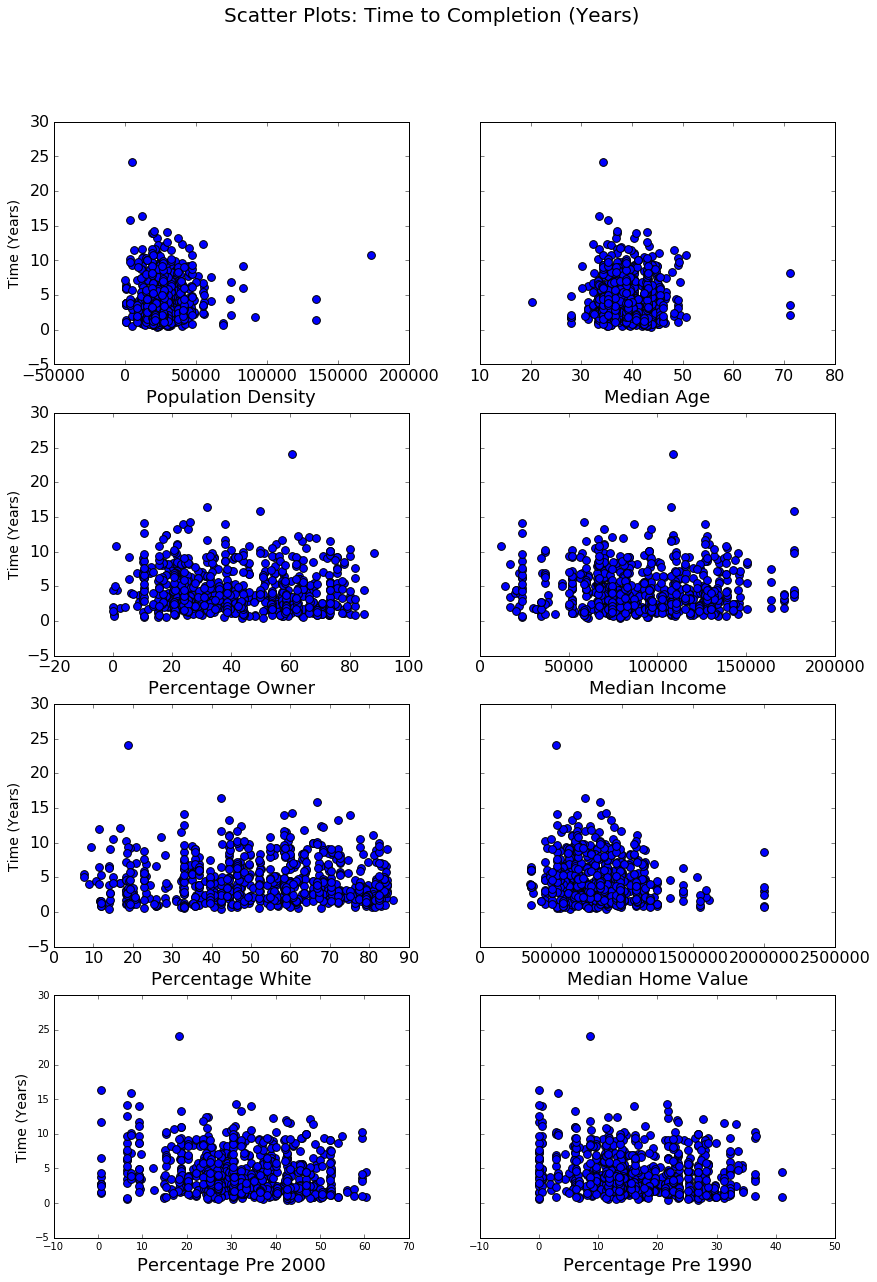

In [144]:
def joint_scatter(variable, title, yaxis,df=df, color='blue'):
    fig, ax = plt.subplots(4, 2, figsize=(14,20), sharey=True)
    plt.suptitle(title, fontsize=20)
    #plt.ylim([0,25])
    for m in range(3):
        for n in range(2):
            ax[m, n].tick_params(axis='both', which='major', labelsize=16)
    
    ax[0, 0].scatter(df['pop_density'], df[variable], s=60, color=color, edgecolors='black')
    ax[0, 0].set_xlabel('Population Density', fontsize=18)
    ax[0, 0].set_ylabel(yaxis, fontsize=14)
    ax[1, 0].scatter(df['perc_owner'], df[variable], s=60, color=color, edgecolors='black')
    ax[1, 0].set_xlabel('Percentage Owner', fontsize=18)
    ax[1, 0].set_ylabel(yaxis, fontsize=14)
    ax[2, 0].scatter(df['perc_white'], df[variable], s=60, color=color, edgecolors='black')
    ax[2, 0].set_xlabel('Percentage White', fontsize=18)
    ax[2, 0].set_ylabel(yaxis, fontsize=14)
    ax[0, 1].scatter(df['median_age'], df[variable], s=60, color=color, edgecolors='black')
    ax[0, 1].set_xlabel('Median Age', fontsize=18)
    ax[1, 1].scatter(df['median_income'], df[variable], s=60, color=color, edgecolors='black')
    ax[1, 1].set_xlabel('Median Income', fontsize=18)
    ax[2, 1].scatter(df['median_homevalue'], df[variable], s=60, color=color, edgecolors='black')
    ax[2, 1].set_xlabel('Median Home Value', fontsize=18)
    ax[3, 0].scatter(df['perc_pre_2000'], df[variable], s=60, color=color, edgecolors='black')
    ax[3, 0].set_xlabel('Percentage Pre 2000', fontsize=18)
    ax[3, 0].set_ylabel(yaxis, fontsize=14)
    ax[3, 1].scatter(df['perc_pre_1990'], df[variable], s=60, color=color, edgecolors='black')
    ax[3, 1].set_xlabel('Percentage Pre 1990', fontsize=18)
    #ax[0, 1].scatter(df['perc_old'], df[variable], s=60)
    #ax[0, 1].set_xlabel('Percentage Old', fontsize=18)
    #ax[1, 1].scatter(df['perc_rich'], df[variable], s=60)
    #ax[1, 1].set_xlabel('Percentage Rich', fontsize=18)

joint_scatter('project_time_years','Scatter Plots: Time to Completion (Years)', 'Time (Years)')

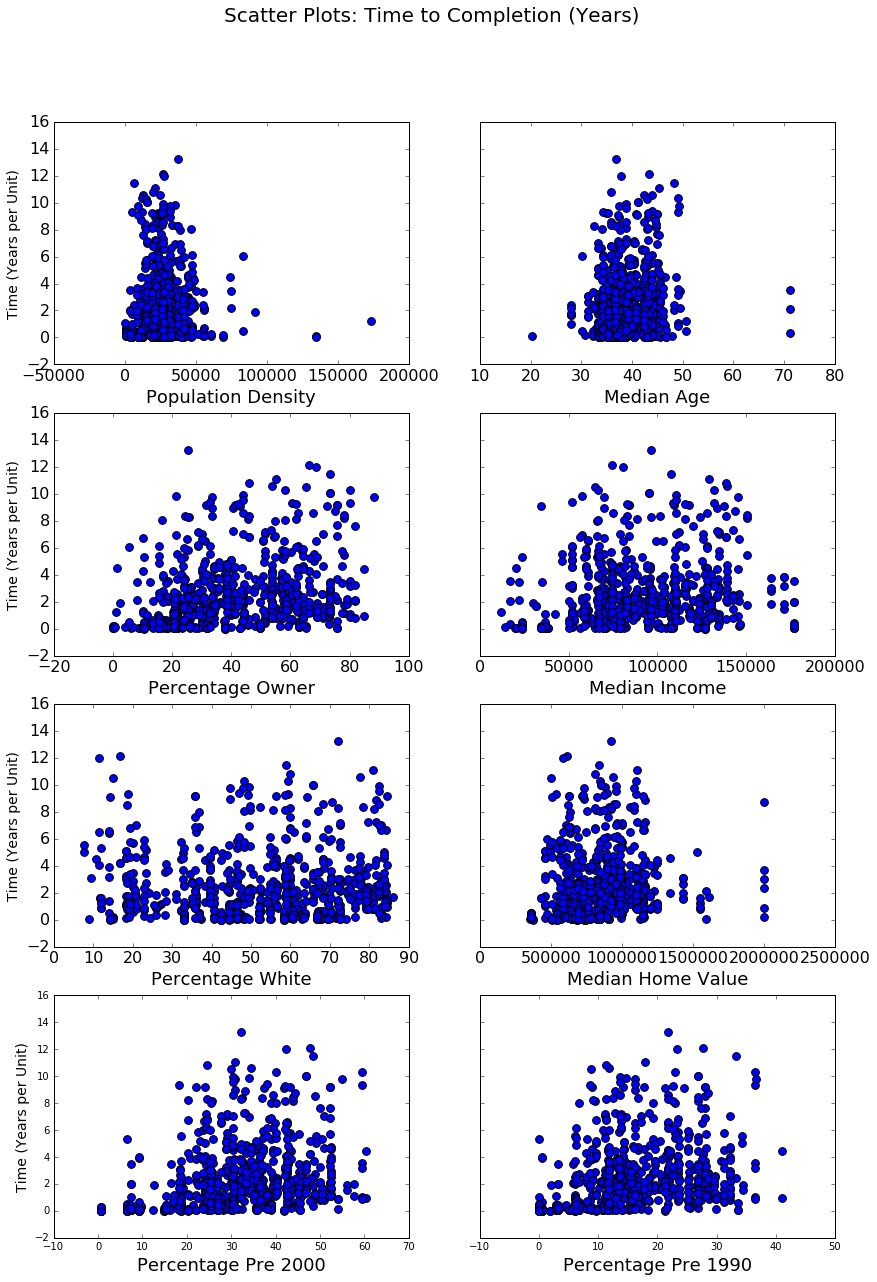

In [145]:
joint_scatter('years_per_unit', 'Scatter Plots: Time to Completion (Years)', 'Time (Years per Unit)')

## Scatter Entitlement Times

In [146]:
df2 = df[pd.notnull(df['BP_date'])]

In [147]:
#scatter plots by entitlement times
df2['permit_time']=df2.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)
df2['permit_time_per_unit']=df2['permit_time']/df2['units']

/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


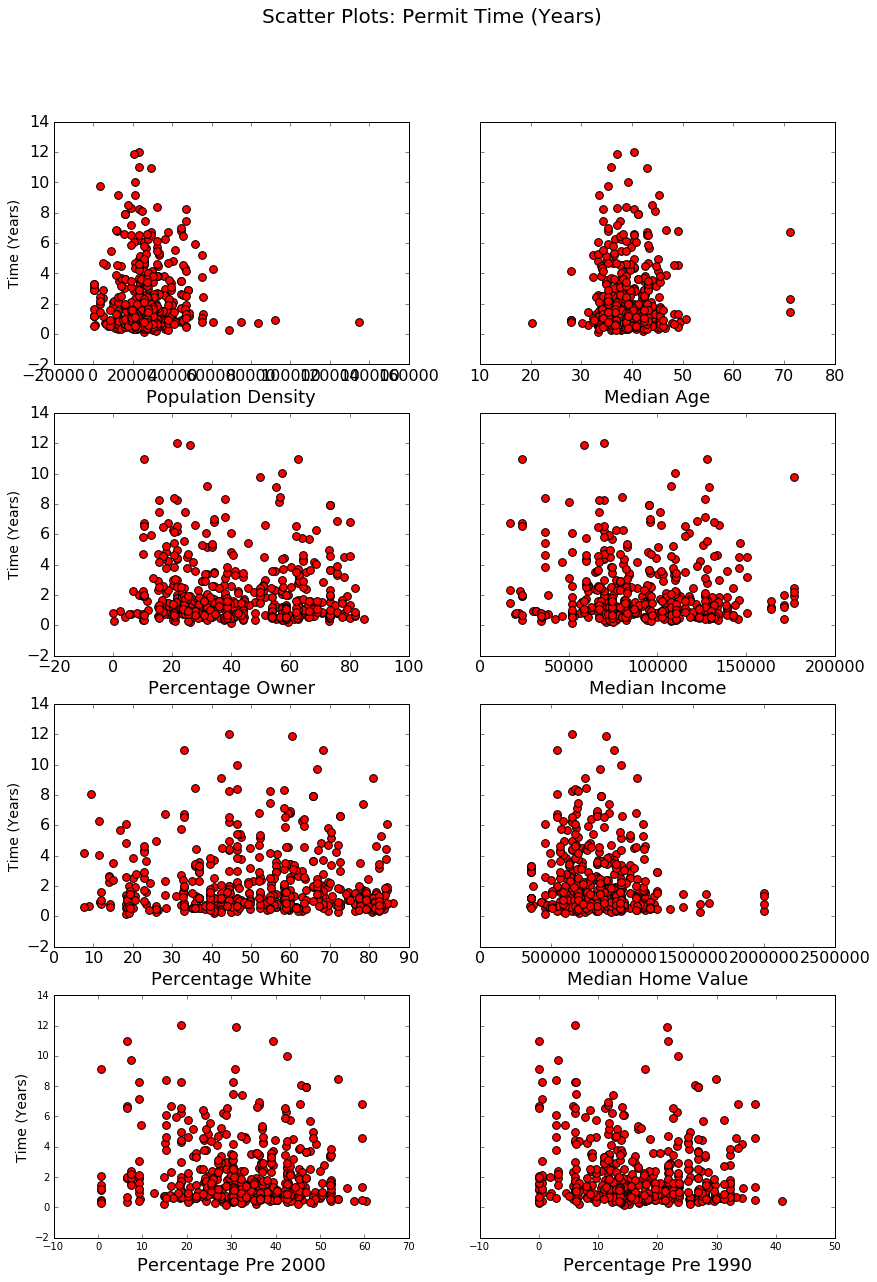

In [148]:
joint_scatter('permit_time', 'Scatter Plots: Permit Time (Years)', 'Time (Years)', df=df2, color='red')

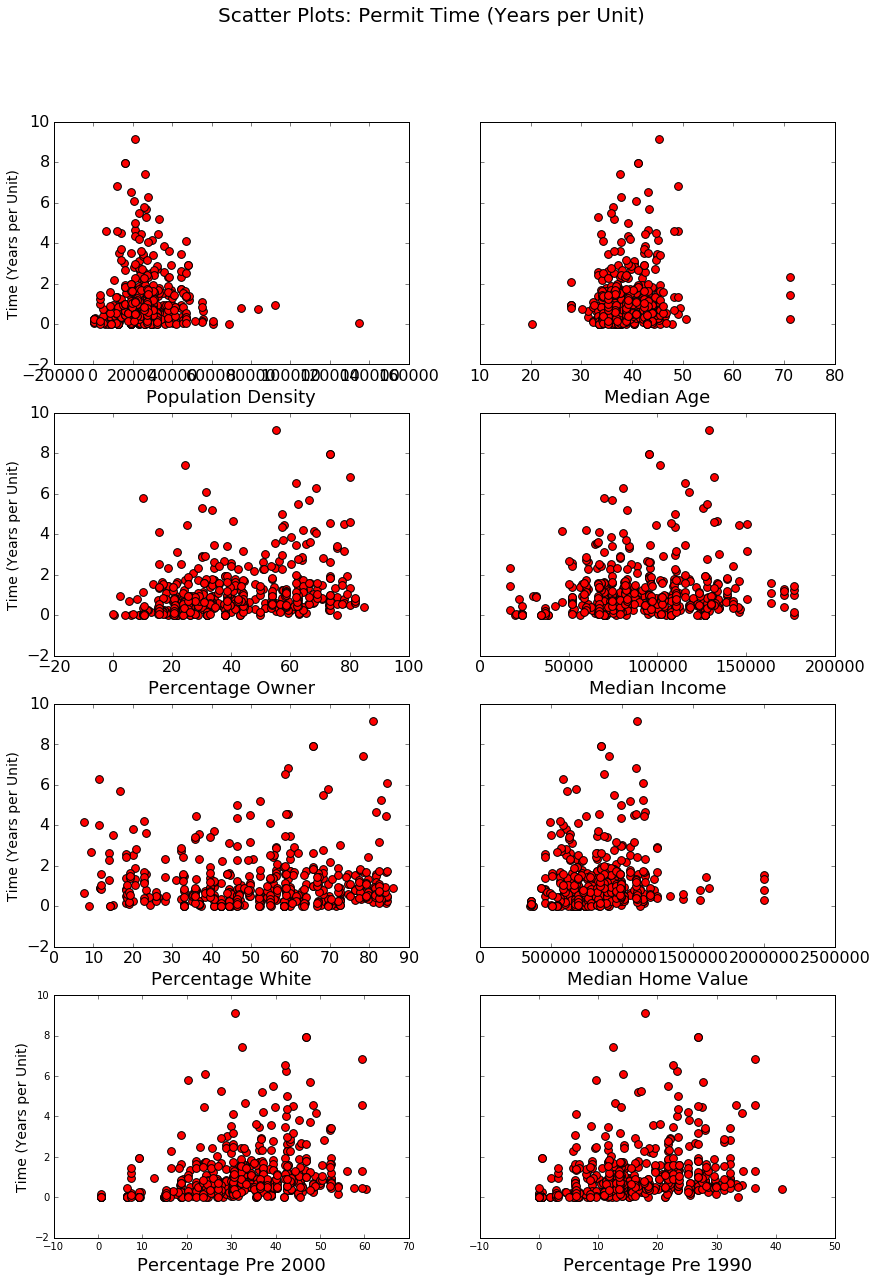

In [149]:
joint_scatter('permit_time_per_unit', 'Scatter Plots: Permit Time (Years per Unit)', 'Time (Years per Unit)', df=df2, color='red')

## Big Project Scatter Plots

In [150]:
df_big=df[df['units']>=10]

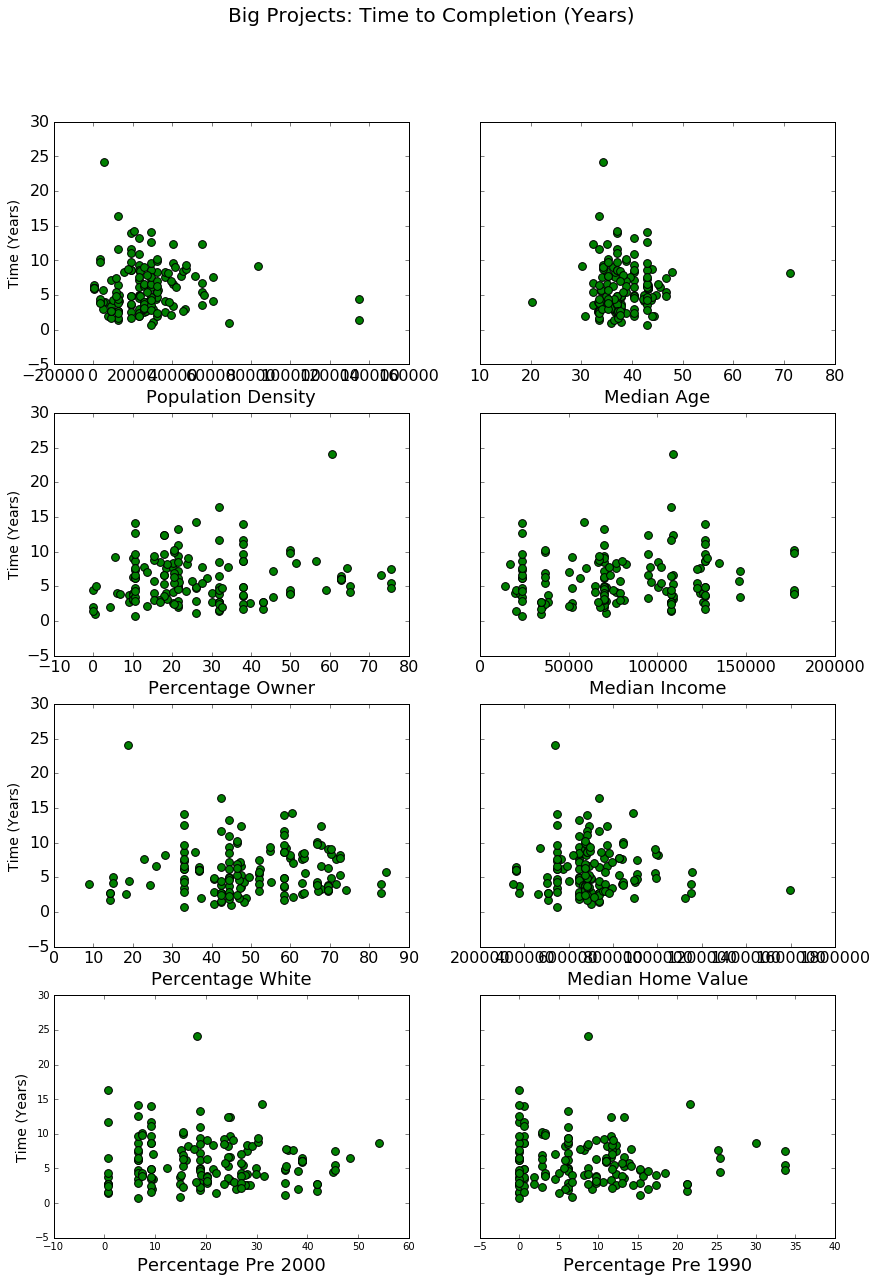

In [151]:
joint_scatter('project_time_years', 'Big Projects: Time to Completion (Years)', 'Time (Years)', df=df_big, color='green')

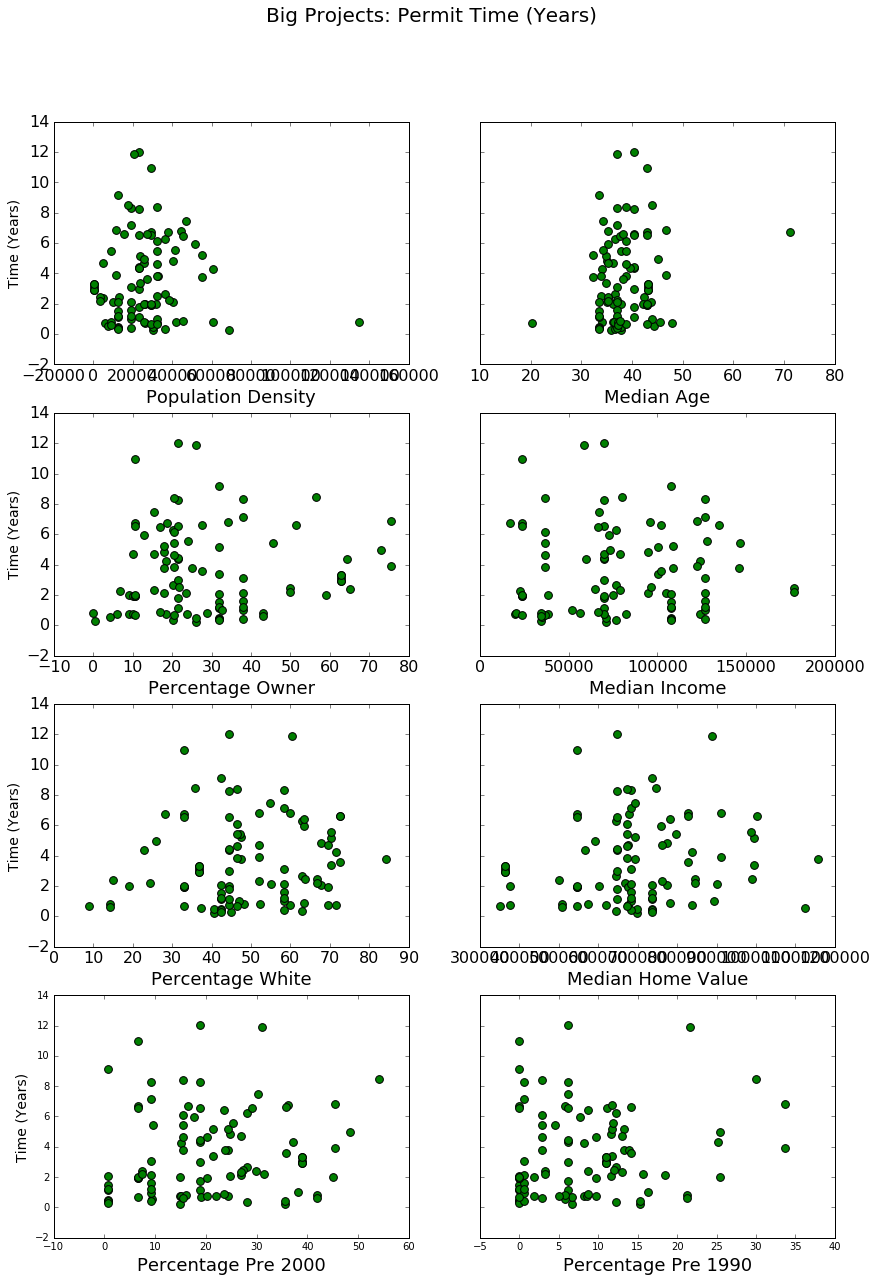

In [152]:
df_big=df_big[pd.notnull(df_big['BP_date'])] #drop all without BP date for permitting time graphs
df_big['permit_time']=df_big.apply(lambda x: ((dateutil.parser.parse(x['BP_date']) - dateutil.parser.parse(x['first_date'])).days)/365, axis=1)
joint_scatter('permit_time', 'Big Projects: Permit Time (Years)', 'Time (Years)', df=df_big, color='green')